## Convolutional Neural Networks Project: Write an Algorithm for a Dog Identification App 



In this notebook, We create an algorithm that could be used as part of a mobile or web app.  At the end of this project, the code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of the finished project.<br>
![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, We piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.

### The Road Ahead

The notebook is broken into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write a custom Algorithm
* [Step 7](#step7): Test the Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, We import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, a dataset of human images is imported, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, We demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


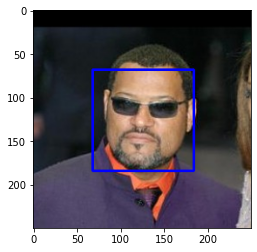

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

We Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that the algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_faces_short = [face_detector(image) for image in human_files_short]
human_faces_in_dog_images = [face_detector(image) for image in dog_files_short]

human_faces_percent = (human_faces_short.count(True) / len(human_faces_short)) * 100
human_faces_in_dog_images_percent = (human_faces_in_dog_images.count(True) / len(human_faces_in_dog_images)) * 100
print("The percentage of the first 100 images in human_files that have a detected human face is: {0} %".format(human_faces_percent))
print("The percentage of the first 100 images in dog_files that have a detected human face is: {0} %".format(human_faces_in_dog_images_percent))

The percentage of the first 100 images in human_files that have a detected human face is: 99.0 %
The percentage of the first 100 images in dog_files that have a detected human face is: 12.0 %


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [10]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dogs_in_human_images = [dog_detector(image) for image in human_files_short]
dogs_in_dog_images = [dog_detector(image) for image in dog_files_short]
dogs_in_human_images_percent = (dogs_in_human_images.count(True) / len(dogs_in_human_images)) * 100
dogs_in_dog_images_percent = (dogs_in_dog_images.count(True) / len(dogs_in_dog_images)) * 100

print("The percentage of the first 100 images in human_files that have a detected dog face is: {0} %".format(dogs_in_human_images_percent))
print("The percentage of the first 100 images in dog_files that have a detected dog face is: {0} %".format(dogs_in_dog_images_percent))

The percentage of the first 100 images in human_files that have a detected dog face is: 0.0 %
The percentage of the first 100 images in dog_files that have a detected dog face is: 100.0 %


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds.  We create the CNN _from scratch_ (no transfer learning _yet_!), and we want to attain a test accuracy of at least 1%.  In Step 5 of this notebook, we use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel <br>
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel <br>
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador <br>
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████████| 836/836 [00:14<00:00, 58.65it/s]


### (IMPLEMENTATION) Model Architecture

We create a CNN to classify dog breed.  At the end of the code cell block, we summarize the layers of the model by executing the line:

In [12]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

### Define the architecture

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(133, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 128)       7

### Compile the Model

In [13]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Now, we train the model. We use model checkpointing to save the model that attains the best validation loss.

In [14]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/10
334/334 [==============================] - ETA: 0s - loss: 4.8860 - accuracy: 0.0070
Epoch 00001: val_loss improved from inf to 4.87365, saving model to saved_models\weights.best.from_scratch.hdf5
334/334 [==============================] - 51s 152ms/step - loss: 4.8860 - accuracy: 0.0070 - val_loss: 4.8737 - val_accuracy: 0.0108
Epoch 2/10
334/334 [==============================] - ETA: 0s - loss: 4.8749 - accuracy: 0.0099
Epoch 00002: val_loss improved from 4.87365 to 4.86769, saving model to saved_models\weights.best.from_scratch.hdf5
334/334 [==============================] - 50s 149ms/step - loss: 4.8749 - accuracy: 0.0099 - val_loss: 4.8677 - val_accuracy: 0.0108
Epoch 3/10
334/334 [==============================] - ETA: 0s - loss: 4.8608 - accuracy: 0.0124
Epoch 00003: val_loss improved from 4.86769 to 4.84254, saving model to saved_models\weights.best.from_scratch.hdf5
334/334 [==============================] - 50s 150ms/step - loss: 4.8608 - accuracy: 0.0124 - val_lo

### Load the Model with the Best Validation Loss

In [15]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

We try out model on the test dataset of dog images.  We want to make sure that the test accuracy is greater than 1%.

In [16]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 7.0574%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

### Obtain Bottleneck Features

In [17]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [18]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [19]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [20]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
330/334 [============================>.] - ETA: 0s - loss: 7.9610 - accuracy: 0.2262
Epoch 00001: val_loss improved from inf to 3.52408, saving model to saved_models\weights.best.VGG16.hdf5
334/334 [==============================] - 1s 4ms/step - loss: 7.9100 - accuracy: 0.2296 - val_loss: 3.5241 - val_accuracy: 0.4539
Epoch 2/20
318/334 [===========================>..] - ETA: 0s - loss: 2.1504 - accuracy: 0.6071
Epoch 00002: val_loss improved from 3.52408 to 2.79481, saving model to saved_models\weights.best.VGG16.hdf5
334/334 [==============================] - 1s 3ms/step - loss: 2.1310 - accuracy: 0.6109 - val_loss: 2.7948 - val_accuracy: 0.5485
Epoch 3/20
334/334 [==============================] - ETA: 0s - loss: 1.2295 - accuracy: 0.7425
Epoch 00003: val_loss improved from 2.79481 to 2.13472, saving model to saved_models\weights.best.VGG16.hdf5
334/334 [==============================] - 1s 3ms/step - loss: 1.2295 - accuracy: 0.7425 - val_loss: 2.1347 - val_accuracy: 0.6

### Load the Model with the Best Validation Loss

In [21]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [22]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 72.7273%


### Predict Dog Breed with the Model

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

Now, we use another transfer learning model to create a CNN that can identify dog breed from images.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, we use the bottleneck features from a different pre-trained model.  To make things easier, the features have been pre-computed for Resnet network.<br>
[ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features

The files are encoded as such:

    DogResnet50Data.npz
    
Download the bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, we extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

In [23]:
### Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

We create a CNN to classify dog breed.  At the end of the code cell block, we summarize the layers of the model by executing the line:

In [24]:
### Define your architecture.
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [25]:
### TODO: Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

We train the model in the code cell below. Model checkpointing is used to save the model that attains the best validation loss.  

In [26]:
### Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=32, callbacks=[checkpointer], verbose=1)

Epoch 1/20
199/209 [===========================>..] - ETA: 0s - loss: 1.8152 - accuracy: 0.5678
Epoch 00001: val_loss improved from inf to 0.86411, saving model to saved_models\weights.best.Resnet50.hdf5
209/209 [==============================] - 1s 3ms/step - loss: 1.7723 - accuracy: 0.5751 - val_loss: 0.8641 - val_accuracy: 0.7473
Epoch 2/20
202/209 [===========================>..] - ETA: 0s - loss: 0.4680 - accuracy: 0.8608
Epoch 00002: val_loss improved from 0.86411 to 0.73614, saving model to saved_models\weights.best.Resnet50.hdf5
209/209 [==============================] - 1s 3ms/step - loss: 0.4656 - accuracy: 0.8617 - val_loss: 0.7361 - val_accuracy: 0.7617
Epoch 3/20
194/209 [==========================>...] - ETA: 0s - loss: 0.2625 - accuracy: 0.9214
Epoch 00003: val_loss improved from 0.73614 to 0.68977, saving model to saved_models\weights.best.Resnet50.hdf5
209/209 [==============================] - 1s 3ms/step - loss: 0.2601 - accuracy: 0.9219 - val_loss: 0.6898 - val_accu

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [27]:
### Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Testing the model on the test dataset of dog images. We want the test accuracy to be greater than 60%.

In [28]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.6986%


### (IMPLEMENTATION) Predict Dog Breed with the Model

We write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by our model.  

Similar to the analogous function in Step 5, the function has three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.

In [29]:
### A function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [30]:
Resnet50_predict_breed('Belgian_sheepdog_01482.jpg')

'Belgian_sheepdog'

---
<a id='step6'></a>
## Step 6: Write your Algorithm

We write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

We use the `face_detector` and `dog_detector` functions developed above.We use the CNN from Step 5 to predict dog breed.  

### (IMPLEMENTATION) Write the Algorithm

In [31]:
### TODO: Write custom algorithm.

import matplotlib.image as mpimg

def custom_algorithm(image_path):
    plt.imshow(mpimg.imread(image_path))
    dog_in_picture = dog_detector(image_path)
    human_in_picture = face_detector(image_path)
    result = ''
    
    if dog_in_picture:
        result = Resnet50_predict_breed(image_path)
        print(result)
        
    elif human_in_picture:
        result = Resnet50_predict_breed(image_path)        
        print('hello, human!')
        print('you look like a ...')
        print(result)
    else:
        print('no dogs or humans detected in provided image')

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, we will take the new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test the Algorithm on Sample Images!

Test the algorithm on images on your computer.

Akita


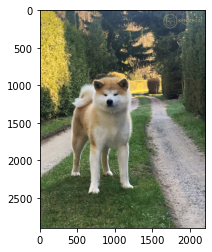

In [32]:
##  Execute your algorithm from Step 6 on
## at on images on your computer.
## Feel free to use as many code cells as needed.
custom_algorithm('test_images/dog_test/akita.jpg')

Bloodhound


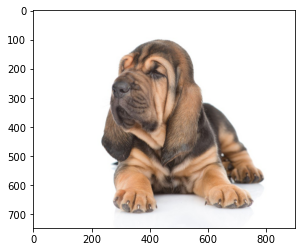

In [33]:
custom_algorithm('test_images/dog_test/bloodhound.jpg')

Dalmatian


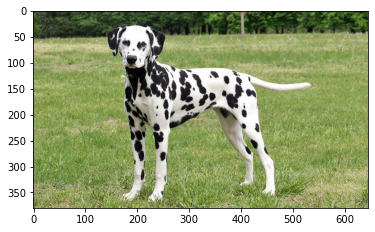

In [34]:
custom_algorithm('test_images/dog_test/dalmatian.jpg')

hello, human!
you look like a ...
Beagle


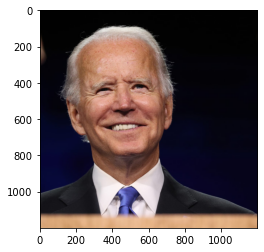

In [35]:
human_images_paths = ['test_images/human_test/human_photo1.jpg', 'test_images/human_test/human_photo2.jpg', 'test_images/human_test/human_photo3.jpg']

custom_algorithm(human_images_paths[0])

hello, human!
you look like a ...
Lowchen


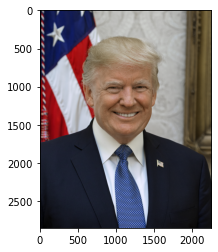

In [36]:
custom_algorithm(human_images_paths[1])

hello, human!
you look like a ...
Nova_scotia_duck_tolling_retriever


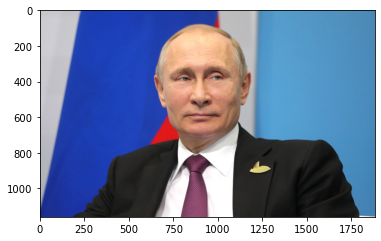

In [37]:
custom_algorithm(human_images_paths[2])